In [26]:
import handle_data
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import plot_results
import numpy as np

In [27]:
variable_to_plot = "AvgTimeToGate"

In [28]:
def import_data():
    # Import the data
    data = handle_data.csv_to_dataframe("logfiles.csv")
    # Remove outliers from training and val
    data = handle_data.remove_faulty(data, variable_to_plot, 1.5, ["INI", "ADA", "HO", "VAL"])

    training, val, test = handle_data.split_data(data)

    return training, val, test

In [29]:
training, val, test = import_data()

[DEBUG] Reading logfiles.csv into dataframe
[DEBUG] Finished reading logfiles.csv into dataframe after 0.5328142642974854 seconds
Input data shape:  (127908, 62)
Shape after removing outliers:  (126796, 62)


In [30]:
def get_distance_from_mean(training, test):
    """
    This function will calculate the distance from the mean for every scenario, and return a dataframe containing 2 columns: the distance from mean
    and the corresponding mean value for every sample. It will do this for both the training and test dataset.
    """
    
    # Training first
    full_data_training = pd.concat([training["Output"], training["Input"]], axis=1)
    data_to_plot_training = pd.DataFrame(columns = ["Value", "DistanceFromMean"])
    
    for part in ["INI", "ADA"]:
        part_data = full_data_training[(full_data_training['IdentifierType'] == part)]
        scenarios = set(part_data['IdentifierScenario'])
        for scenario in scenarios:
            df = full_data_training[(full_data_training['IdentifierScenario'] == scenario) & (full_data_training['IdentifierType'] == part)]
            
            values = df[variable_to_plot]
            mean = values.mean()
            deviation_from_mean = values - mean
            
            combined_df = pd.DataFrame()
            combined_df["Value"] = values
            combined_df["DistanceFromMean"] = deviation_from_mean
            combined_df["Value"] = mean
            data_to_plot_training = pd.concat([combined_df, data_to_plot_training], axis=0)
            
    # Test set
    full_data_test = pd.concat([test["Output"], test["Input"]], axis=1)
    data_to_plot_test = pd.DataFrame(columns = ["Value", "DistanceFromMean"])
    
    part = "VAL"
    part_data = full_data_test[(full_data_test['IdentifierType'] == part)]
    scenarios = set(part_data['IdentifierScenario'])
    for scenario in scenarios:
        df = full_data_test[(full_data_test['IdentifierScenario'] == scenario) & (full_data_test['IdentifierType'] == part)]

        values = df[variable_to_plot]
        mean = values.mean()
        deviation_from_mean = values - mean

        combined_df = pd.DataFrame()
        combined_df["Value"] = values
        combined_df["DistanceFromMean"] = deviation_from_mean
        combined_df["Value"] = mean
        data_to_plot_test = pd.concat([combined_df, data_to_plot_test], axis=0)        
    
    return data_to_plot_training, data_to_plot_test


def minimum_RMSE(distance_from_mean):
    return np.sqrt(sum(distance_from_mean**2 / len(distance_from_mean)))

In [31]:
training_plot, test_plot = get_distance_from_mean(training, test)
x_train = training_plot["Value"]
y_train = training_plot["DistanceFromMean"]
x_test = test_plot["Value"]
y_test = test_plot["DistanceFromMean"]

min_RMSE_train = minimum_RMSE(y_train)
min_RMSE_test = minimum_RMSE(y_test)

print("Minimum train MAE: ", abs(y_train).mean())
print("Mininum train RMSE: ", min_RMSE_train)

print("Minimum test MAE: ", abs(y_test).mean())
print("Minimum test RMSE: ", min_RMSE_test)

Minimum train MAE:  55.32708611058466
Mininum train RMSE:  70.91587789897683
Minimum test MAE:  55.29457386911445
Minimum test RMSE:  70.42025902921525


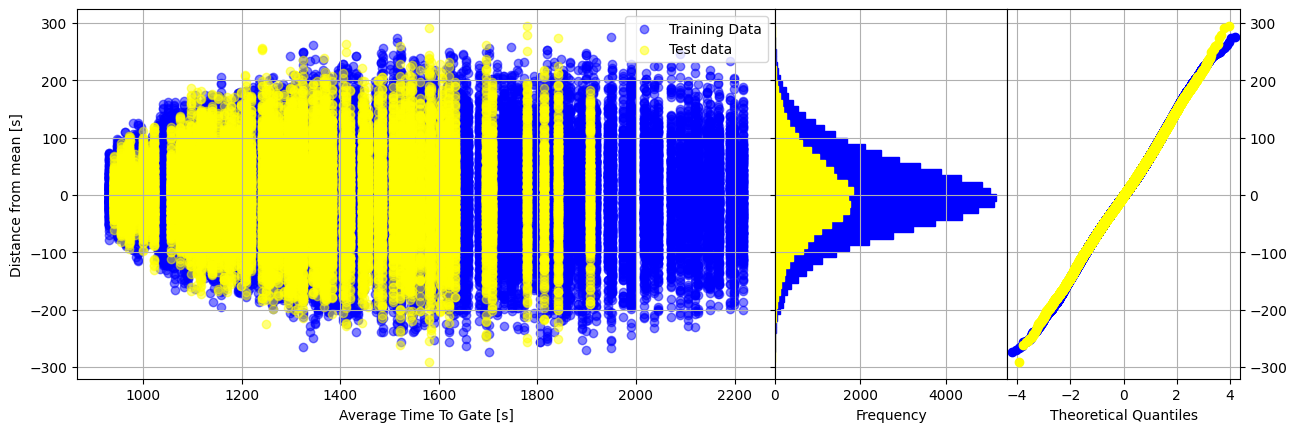

In [32]:
if variable_to_plot == "TotalExpenditure":
    xlabel = "Total Expenditure [€]"
    ylabel = "Distance from mean [€]"
elif variable_to_plot == "AvgTimeToGate":
    xlabel = "Average Time To Gate [s]"
    ylabel = "Distance from mean [s]"

plot_results.qq_plot(x_train, x_test, y_train, y_test, xlabel, ylabel, 'blue', 'yellow')